In [1]:
import glob

import spacy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
en = spacy.load('en_core_web_sm')

In [3]:
train_df = pd.read_csv('./datasets/home-depot/train.csv')
train_df.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634
std,64016.573650,30770.774864,0.533984
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [4]:
train_df.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [5]:
min_rel, max_rel = train_df['relevance'].min(), train_df['relevance'].max()
print(min_rel, max_rel)

1.0 3.0


In [6]:
X = train_df[['product_title', 'search_term', 'product_description']] 
y = train_df['relevance']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,)

In [8]:
def preprocess(text):
    # TODO:
    # remove stopwords, etc.
    # try spacy stopwords, or something else
    return text


# TODO: Try BM25



tfidf_model = TfidfVectorizer(
    strip_accents='ascii',
    max_df=0.95,
    min_df=0.01,
    max_features=5000
).fit(X_train['product_description'])

In [9]:
def cosim(queries, candidates):  #, pairwise=True):
#     if not pairwise and queries.shape == candidates.shape:
#         dot = np.sum(queries.toarray() * candidates.toarray(), axis=1)
#         mag = np.linalg.norm(queries, axis=1) * np.linalg.norm(candidates, axis=1)
#         return dot / mag
    return cosine_similarity(queries, candidates)

In [10]:
def change_pred_range(pred, low=1.0, high=3.0):
    return pred / pred.max() * (high-low) + low

In [11]:
# MSE
def mse(pred, target):
    return np.mean((pred.diagonal() - target) ** 2)

In [12]:
# when using product title; train set
k = 5000

tfidf_candidates = tfidf_model.transform(X_train['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_train['product_title'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_train[:k])

0.7729206680135123

In [13]:
# when using product title; test set
k = 5000

tfidf_candidates = tfidf_model.transform(X_test['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_test['product_title'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_test[:k])

0.774700383239989

In [14]:
# when using search term; train set
k = 5000

tfidf_candidates = tfidf_model.transform(X_train['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_train['search_term'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_train[:k])

1.3888422935067484

In [15]:
# when using search term; test set
k = 5000

tfidf_candidates = tfidf_model.transform(X_test['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_test['search_term'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_test[:k])

1.4040302438725247

In [16]:
# visual inspection of quality
# randomly sample about 20 examples

k = 20

idxs = np.random.randint(0, len(X_test), size=(k,))
X_test.iloc[idxs][['product_title', 'search_term', 'product_description']]

,product_title,search_term,product_description
42943,Eaton 40-Amp 3 in. Triple Pole Type BR Circuit...,3 pole range reciptical,The 40-Amp 3 in. Triple-Pole Type BR Circuit B...
73057,Rust-Oleum Universal 12 oz. All Surface Satin ...,eyeball in all black,Rust-Oleum Universal 12 oz. All Surface Satin ...
55720,BEHR Premium Plus Ultra #350A-3 Pale Sunshine ...,pale smoke behr,BEHR Premium Plus Ultra Eggshell Enamel Interi...
43308,Bull Outdoor Products 4-Burner Built-In Natura...,built in natural gas grill,This 4-burner built-in island grill from Bull ...
15021,Jack Post Country Garden Natural Wood High Bac...,wood swing,Sit back and relax with our High Back Swing Se...
55482,Glidden DUO #HDGCN10D Misty Grey Green Latex I...,flat latex grey paint,Glidden DUO formula is more than just a paint....
50739,Milwaukee Titanium Drill Bit Kit (14-Piece),titanium drill bits,The 14-Piece Milwaukee Thunderbolt Titanium co...
73012,U.S. Ceramic Tile Color Collection Matte Bone ...,u.s. ceramics bone,This U.S. Ceramic Tile Color Collection Matte ...
54729,Trinity 36 in. x 14 in. Shelf Liners (4-Pack),contact paoer,Custom fit plastic shelf liners ensure product...
69557,Delta 1/2 in. x 4-1/2 in. 150-Grit Spindle San...,sanding sleeves for a wen sander,The Delta 1/2 in. x 4-1/2 in. 150-Grit Spindle...


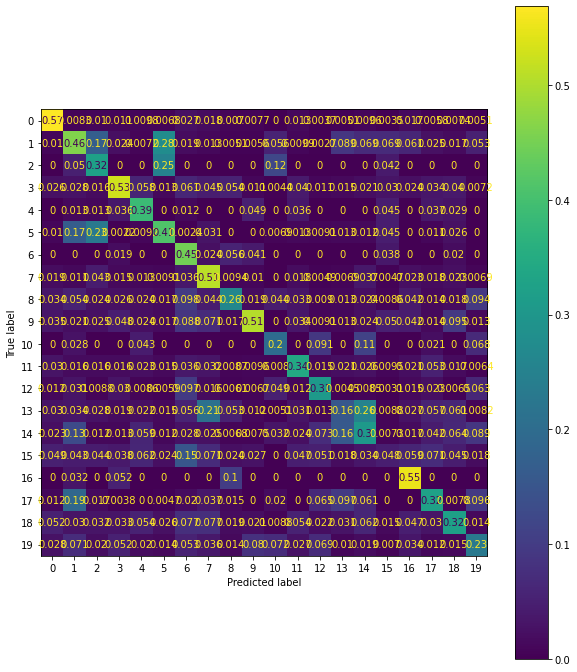

In [17]:
tfidf_candidates = tfidf_model.transform(X_test.iloc[idxs]['product_description'])
tfidf_queries = tfidf_model.transform(X_test.iloc[idxs]['product_title'])
y_pred_rand = cosim(tfidf_queries, tfidf_candidates)


ConfusionMatrixDisplay(y_pred_rand).plot()
fig = plt.gcf()
fig.set_size_inches(10, 12)
plt.show()

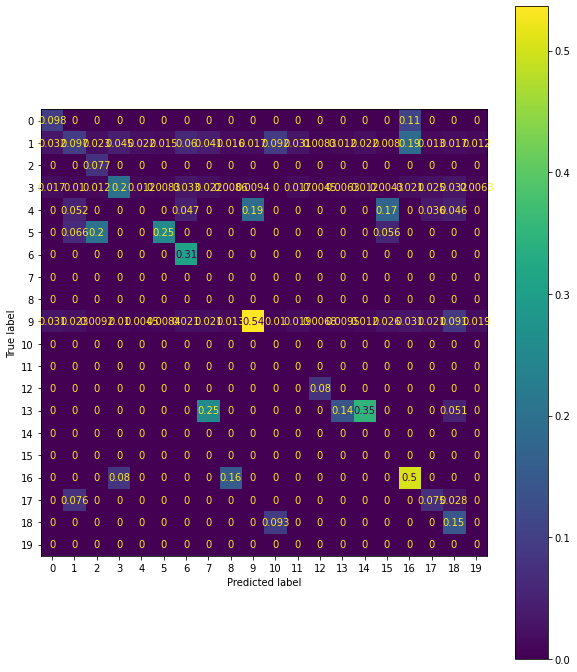

In [18]:
tfidf_candidates = tfidf_model.transform(X_test.iloc[idxs]['product_description'])
tfidf_queries = tfidf_model.transform(X_test.iloc[idxs]['search_term'])
y_pred_rand = cosim(tfidf_queries, tfidf_candidates)


ConfusionMatrixDisplay(y_pred_rand).plot()
fig = plt.gcf()
fig.set_size_inches(10, 12)
plt.show()

## Resume Dataset - 1

In [19]:
with open('./datasets/resume-corpus/jds.txt', 'r') as f:
    jds = f.read()

In [20]:
# all the text files
files = glob.glob('./datasets/resume-corpus/resumes_corpus/*.txt')
role_info = []
for file in files:
    with open(file, encoding='latin-1', errors='replace') as f:
        role_info.append(f.read())

In [21]:
# tfidf_model = TfidfVectorizer(
#     encoding='utf-8',
#     strip_accents='ascii',
#     max_df=0.90,
#     min_df=0.01,
#     max_features=4096
# ).fit(role_info)

tfidf_model_stopwords = TfidfVectorizer(
    encoding='utf-8',
    stop_words=en.Defaults.stop_words,
    strip_accents='ascii',
    max_df=0.90,
    min_df=0.01,
    max_features=4096
).fit(role_info)


# new_tfidf_model = TfidfVectorizer(
#     encoding='latin-1',
#     strip_accents='ascii',
#     decode_error='replace',
#     max_df=0.95,
#     min_df=0.01,
#     max_features=4096
# )

/home/kirito/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'nt', 've'] not in stop_words.
  warnings.warn(


In [134]:
# new_tfidf_model.vocabulary_ = tfidf_model.vocabulary_
# new_tfidf_model.fixed_vocabulary_ = tfidf_model.fixed_vocabulary_
# new_tfidf_model.idf_ = tfidf_model.idf_
# new_tfidf_model.stop_words_ = tfidf_model.stop_words_

In [28]:
candidate = tfidf_model_stopwords.transform(['Senior Systems Administrator'])
(candidate.toarray() == 0).sum()

4093

In [23]:
job_descriptions = {}

for i, jd in enumerate(jds.split('::::::\n::::::\n')):
    # first occurrence of ':::'
    idx1 = jd.find(':::')
    idx2 = jd.find(':::', idx1+3)
    role = jd[idx1+3: idx2].split(';')[0]
    job_descriptions[role] = role + ' ' + jd[idx2+3:]
    
#     print('Role:', role)
#     print('JD:', jd[idx2+3:])
#     if i == 2:
#         break

In [24]:
len(job_descriptions)

4

In [29]:
tfidf_candidates = tfidf_model_stopwords.transform(list(job_descriptions.values()))

In [30]:
(tfidf_candidates.toarray() == 0).sum()

15839

In [32]:
with open('./datasets/resume-corpus/resumes_corpus/00045.txt', errors='replace') as f:
    print(f.read())
    query = tfidf_model_stopwords.transform([f.read()],)
    
scores = cosine_similarity(query, tfidf_candidates)

COOK COOK COOK - SOUTHERN HILLS COUNTRY CLUB Tulsa, OK To gain an opportunity in field that allows for growth and advancement. Authorized to work in the US for any employer Work Experience COOK SOUTHERN HILLS COUNTRY CLUB March 2015 to Present Help to prepare and cook food that members order while maintaining food and health regulations. Assist in the training of new employees as needed. COOK REASORS February 2013 to March 2015 Cook and prep food while maintaining health and food regulations. DATABASE ADMINISTRATOR UNITED STATES MARINE CORPS April 2010 to January 2011 Monitor daily documentation, accountability, and qualifications of employees. Trained new employees regularly. AIRFRAME MECHANIC UNITED STATES MARINE CORPS October 2009 to January 2011 Repair and maintain the quality of the aircrafts. Serve Duty and watch as needed. Education BS in Game art and design Southern New Hampshire University July 2018 to July 2020 HIGH SCHOOL DIPLOMA June 2009 Skills Microsoft office (3 years) M

In [33]:
scores

array([[0., 0., 0., 0.]])